In [1]:
import numpy as np
from keras.preprocessing import sequence
from tqdm import tqdm
import preprocessing as preproc
from utils import *
import os

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


# Run once for train folder and once for val folder

In [11]:
path = data_path+"app-100-length-15/"

# current_folder = train_folder
current_folder = val_folder

base_path = path + current_folder

In [12]:
NR_TRAIN_INSTANCES = 1000000
BATCH_SIZE = 2048
MAX_CAPTION_LEN = 15

## Load general datastruct

In [13]:
unique_words = preproc.load_obj(path+general_datastruct_folder+"unique_words")
word2index = preproc.load_obj(path+general_datastruct_folder+"word2index")
index2word = preproc.load_obj(path+general_datastruct_folder+"index2word")
VOCAB_SIZE = len(unique_words)
print(len(unique_words))

849


# Save img vgg features batch

In [14]:
def save_image_vgg_batches(images_precomputed_vgg_features,current_index):
    
    for batch_index in tqdm(range(len(images_precomputed_vgg_features) / BATCH_SIZE)):
        img_vgg_feature_list = []

        for elem_in_batch in range(BATCH_SIZE):
            img_vgg_feature = np.expand_dims(images_precomputed_vgg_features[batch_index*BATCH_SIZE + elem_in_batch],axis=0)
            img_vgg_feature_list.append(img_vgg_feature)

        img_vgg_batch = np.vstack(img_vgg_feature_list)
        
        print("\t Batch %d img_vgg_batch.shape = %s"%(batch_index,str(img_vgg_batch.shape)))
        
        preproc.save_array_with_folder_create(base_path + batch_folder + images_vgg_4096_folder,'img_vgg_feature_bucket_' + str(current_index)
                   + '_batch_' + str(format(batch_index, "06"))+ '.bc',img_vgg_batch)


In [15]:
for index in range(5):
    print("-----Index %d -----"%index)
    
    images_precomputed_vgg_features = preproc.read_serialized_np_arr(base_path+images_vgg_4096_folder+"vgg_features_"+str(index)+".bc"
                                                                  ,nr_instances = NR_TRAIN_INSTANCES )
    
    print("\t images_precomputed_vgg_features.shape = "+str(images_precomputed_vgg_features.shape))
        
    save_image_vgg_batches(images_precomputed_vgg_features,index)
    
    


-----Index 0 -----


 33%|███▎      | 1/3 [00:00<00:00,  8.33it/s]

	 images_precomputed_vgg_features.shape = (7897, 4096)
	 Batch 0 img_vgg_batch.shape = (2048, 4096)
Creating folder: /home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/batches/images_vgg_4096/
	 Batch 1 img_vgg_batch.shape = (2048, 4096)


100%|██████████| 3/3 [00:00<00:00,  8.69it/s]


	 Batch 2 img_vgg_batch.shape = (2048, 4096)
-----Index 1 -----


 50%|█████     | 1/2 [00:00<00:00,  9.22it/s]

	 images_precomputed_vgg_features.shape = (6073, 4096)
	 Batch 0 img_vgg_batch.shape = (2048, 4096)
	 Batch 1 img_vgg_batch.shape = (2048, 4096)


100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


-----Index 2 -----


 50%|█████     | 1/2 [00:00<00:00,  9.59it/s]

	 images_precomputed_vgg_features.shape = (5837, 4096)
	 Batch 0 img_vgg_batch.shape = (2048, 4096)
	 Batch 1 img_vgg_batch.shape = (2048, 4096)


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


-----Index 3 -----


 50%|█████     | 1/2 [00:00<00:00,  9.40it/s]

	 images_precomputed_vgg_features.shape = (5653, 4096)
	 Batch 0 img_vgg_batch.shape = (2048, 4096)
	 Batch 1 img_vgg_batch.shape = (2048, 4096)


100%|██████████| 2/2 [00:00<00:00,  9.31it/s]


-----Index 4 -----


 50%|█████     | 1/2 [00:00<00:00,  9.53it/s]

	 images_precomputed_vgg_features.shape = (5630, 4096)
	 Batch 0 img_vgg_batch.shape = (2048, 4096)
	 Batch 1 img_vgg_batch.shape = (2048, 4096)


100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


# Save  captions batch

In [16]:
def save_raw_captions_batches(raw_captions,current_index):

    for batch_index in tqdm(range(len(raw_captions)/BATCH_SIZE)):
        caption_list = []

        for elem_in_batch in range(BATCH_SIZE):
            caption_list.append(raw_captions[batch_index*BATCH_SIZE + elem_in_batch])

        captions_batch = np.vstack(caption_list)

#         print("\t Batch %d captions_batch.shape = %s"%(batch_index,str(captions_batch.shape)))
            
        preproc.save_array_with_folder_create(base_path + batch_folder + captions_folder,'caption_bucket_'+str(current_index)
                                              +"_batch_"+str(format(batch_index, "06"))+'.bc',captions_batch)

        
        
def get_indexed_captions(raw_captions):
    indexed_captions = []
    for raw_caption in tqdm(raw_captions):
        indexed_caption = [word2index[caption_word] for caption_word in raw_caption.split()]
        indexed_caption = sequence.pad_sequences([indexed_caption], maxlen=MAX_CAPTION_LEN,padding='post')
        indexed_np_arr = np.asarray(np.squeeze(indexed_caption))

        indexed_captions.append(indexed_np_arr)
    
    return indexed_captions

def save_indexed_captions_batches(indexed_captions,current_index):
    
    for batch_index in tqdm(range(len(indexed_captions)/BATCH_SIZE)):

        indexed_caption_list = []

        for elem_in_batch in range(BATCH_SIZE):
            indexed_caption = np.expand_dims(indexed_captions[batch_index*BATCH_SIZE + elem_in_batch],axis=0)
            indexed_caption_list.append(indexed_caption)

        indexed_captions_batch = np.vstack(indexed_caption_list)

        preproc.save_array_with_folder_create(base_path + batch_folder + indexed_captions_folder,
                                              'indexed_caption_bucket_'+str(current_index)+"_"+ str(format(batch_index, "06"))+ ".bc",
                                              indexed_captions_batch)
        
def save_future_words_captions_batches(indexed_captions,current_index):
    
    for batch_index in tqdm((range(len(indexed_captions)/BATCH_SIZE))):

        indexed_future_word_list = []

        for elem_in_batch in range(BATCH_SIZE):

            caption_indexed = indexed_captions[batch_index*BATCH_SIZE + elem_in_batch]

            enhanced_caption_indexed = np.append(caption_indexed,[word2index["END"]]) #hacky
            word_2_next_word = []

            for i in xrange(0,len(caption_indexed)):
                caption_word_index = enhanced_caption_indexed[i]
                future_word_index = enhanced_caption_indexed[i+1]
                future_indexes = np.zeros(VOCAB_SIZE)
                future_indexes[future_word_index] = 1

                word_2_next_word.append(future_indexes)

            words_2_next_word = np.vstack(word_2_next_word)
            words_2_next_word = np.expand_dims(words_2_next_word,axis=0)

            indexed_future_word_list.append(words_2_next_word)

        indexed_future_words_batch = np.vstack(indexed_future_word_list)

        preproc.save_array_with_folder_create(base_path+batch_folder+indexed_future_words_folder,
                                              'indexed_future_word_bucket_'+str(current_index)
                                              +"_"+str(format(batch_index, "06"))+".bc", 
                   indexed_future_words_batch)
    
def get_prev_indexed_captions(raw_captions):
    prev_indexed_captions = []
    for index,raw_caption in tqdm(enumerate(raw_captions)):
        indexed_caption = [word2index[caption_word] for caption_word in raw_caption.split()]

        #this is where the magic happens
        indexed_caption.insert(0, indexed_caption[0])
        indexed_caption = indexed_caption[:-1]

        indexed_caption = sequence.pad_sequences([indexed_caption], maxlen=MAX_CAPTION_LEN,padding='post')
        indexed_np_arr = np.asarray(np.squeeze(indexed_caption))

        prev_indexed_captions.append(indexed_np_arr)
        
    return prev_indexed_captions

def save_prev_indexed_captions_batches(prev_indexed_captions,current_index):
  
    for batch_index in tqdm(range(len(prev_indexed_captions)/BATCH_SIZE)):
    
        indexed_caption_list = []

        for elem_in_batch in range(BATCH_SIZE):
            indexed_caption = np.expand_dims(prev_indexed_captions[batch_index*BATCH_SIZE + elem_in_batch],axis=0)
            indexed_caption_list.append(indexed_caption)

        indexed_captions_batch = np.vstack(indexed_caption_list)

        preproc.save_array_with_folder_create(base_path + batch_folder + indexed_prev_captions_folder,
                                              'indexed_prev_caption_bucket_'+str(current_index)+"_"
                                              + str(format(batch_index, "06")) + ".bc",
                                              indexed_captions_batch)

In [17]:
for index in range(5):
    print("-----Index %d -----"%index)
    
    raw_captions = preproc.get_truncated_captions_from_batch(base_path + captions_folder, batch_nr = index,
                                                           nr_instances = NR_TRAIN_INSTANCES )
    
    print("\t len(raw_captions) = %d"%len(raw_captions))
        
    save_raw_captions_batches(raw_captions,index)
    
    indexed_captions = get_indexed_captions(raw_captions)
        
    print("\t len(indexed_captions) = %d"%len(indexed_captions))
    
    save_indexed_captions_batches(indexed_captions,index)
    
    save_future_words_captions_batches(indexed_captions,index)
    
    prev_indexed_captions = get_prev_indexed_captions(raw_captions)
    save_prev_indexed_captions_batches(prev_indexed_captions,index)
    
    print("\t len(prev_indexed_captions) = %d"%len(prev_indexed_captions))

-----Index 0 -----


  0%|          | 0/3 [00:00<?, ?it/s]

	 len(raw_captions) = 7897
Creating folder: /home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/batches/captions/
	 len(indexed_captions) = 7897
Creating folder: /home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/batches/indexed-captions/


 33%|███▎      | 1/3 [00:00<00:00,  3.27it/s]

Creating folder: /home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/batches/indexed-future-words/


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
7897it [00:00, 50123.44it/s]
100%|██████████| 3/3 [00:00<00:00, 148.25it/s]


Creating folder: /home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/batches/indexed-prev-captions/
	 len(prev_indexed_captions) = 7897
-----Index 1 -----


  0%|          | 0/2 [00:00<?, ?it/s]

	 len(raw_captions) = 6073
	 len(indexed_captions) = 6073


100%|██████████| 2/2 [00:00<00:00,  3.18it/s]
6073it [00:00, 51900.65it/s]
100%|██████████| 2/2 [00:00<00:00, 146.57it/s]


	 len(prev_indexed_captions) = 6073
-----Index 2 -----


  0%|          | 0/2 [00:00<?, ?it/s]

	 len(raw_captions) = 5837
	 len(indexed_captions) = 5837


100%|██████████| 2/2 [00:00<00:00,  3.28it/s]
5837it [00:00, 50106.43it/s]
100%|██████████| 2/2 [00:00<00:00, 140.09it/s]


	 len(prev_indexed_captions) = 5837
-----Index 3 -----


  0%|          | 0/2 [00:00<?, ?it/s]

	 len(raw_captions) = 5653
	 len(indexed_captions) = 5653


100%|██████████| 2/2 [00:00<00:00,  3.15it/s]
5653it [00:00, 50936.65it/s]
100%|██████████| 2/2 [00:00<00:00, 139.99it/s]


	 len(prev_indexed_captions) = 5653
-----Index 4 -----


  0%|          | 0/2 [00:00<?, ?it/s]

	 len(raw_captions) = 5630
	 len(indexed_captions) = 5630


100%|██████████| 2/2 [00:00<00:00,  3.19it/s]
5630it [00:00, 49336.61it/s]
100%|██████████| 2/2 [00:00<00:00, 142.37it/s]

	 len(prev_indexed_captions) = 5630


# Validation Tests

In [18]:
def get_fqn(target_path):
    inside_folders = os.listdir(target_path)
    return [target_path + inside_folder for inside_folder in inside_folders]

def nr_instances_in_folder(paths):
    nr_instances = 0
    for path in tqdm(paths):
        nr_instances += len(load_array(path))
        
    return nr_instances

In [19]:
caption_batches_paths = get_fqn(base_path+ batch_folder + captions_folder)
img_batches_paths = get_fqn(base_path+ batch_folder + images_vgg_4096_folder)
indexed_caption_batches_paths = get_fqn(base_path+ batch_folder + indexed_captions_folder)
indexed_future_words_paths =  get_fqn(base_path+ batch_folder + indexed_future_words_folder)
indexed_prev_captions_paths = get_fqn(base_path+ batch_folder + indexed_prev_captions_folder)

## Same number of batch folders

In [20]:
print(len(caption_batches_paths))
print(len(img_batches_paths))
print(len(indexed_caption_batches_paths))
print(len(indexed_future_words_paths))
print(len(indexed_prev_captions_paths))

11
11
11
11
11


## Same number of instances in  folders

In [21]:
print(nr_instances_in_folder(caption_batches_paths))
print(nr_instances_in_folder(img_batches_paths))
print(nr_instances_in_folder(indexed_caption_batches_paths))
print(nr_instances_in_folder(indexed_future_words_paths))
print(nr_instances_in_folder(indexed_prev_captions_paths))

 45%|████▌     | 5/11 [00:00<00:00, 47.67it/s]

22528


  9%|▉         | 1/11 [00:00<00:01,  7.69it/s]

22528
22528


100%|██████████| 11/11 [00:00<00:00, 1754.67it/s]

22528
22528


## Visual testing

In [22]:
def get_img_to_caption(img_paths,caption_batches_paths,nr_instances):
    
    img_paths.sort()
    caption_batches_paths.sort()
    
    chosen_img_path = img_paths[0]
    chosen_caption_batch_path = caption_batches_paths[0]
    
    print(chosen_img_path)
    print(chosen_caption_batch_path)
    
    imgs = load_array(chosen_img_path)[:nr_instances]
    captions = load_array(chosen_caption_batch_path)[:nr_instances]
    
    imgs_arr = np.transpose(imgs,(0,2,3,1))
    captions_arr = [caption[0] for caption in captions]

    return(imgs_arr,captions_arr)
    

In [23]:
nr_instances = 50

In [24]:
(imgs,captions) = get_img_to_caption(get_fqn(base_path+images_concat_folder),caption_batches_paths,nr_instances)

/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/images_concat/images_concat_0.bc
/home/docker/fastai-courses/deeplearning1/nbs/persistent/coco/data/app-100-length-15/val/batches/captions/caption_bucket_0_batch_000000.bc


In [25]:
imgs.shape

(50, 224, 224, 3)

/opt/conda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


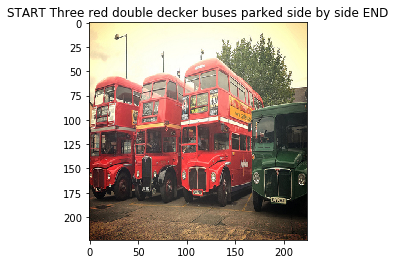

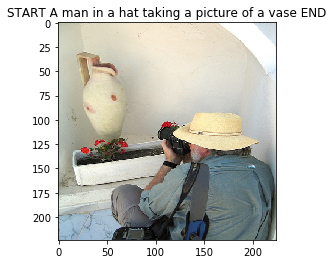

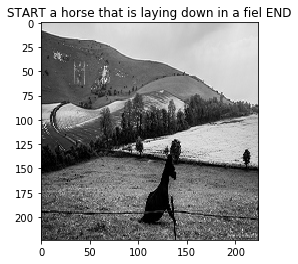

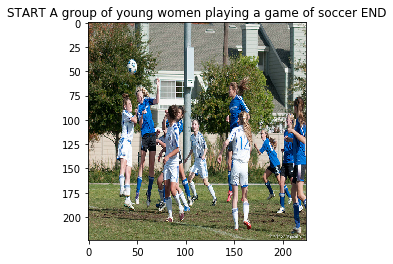

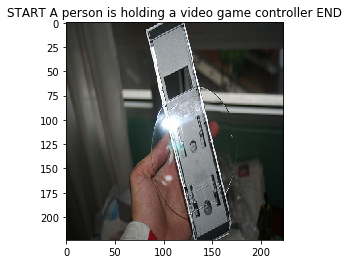

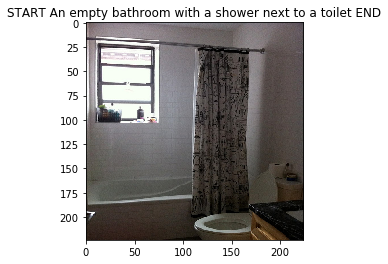

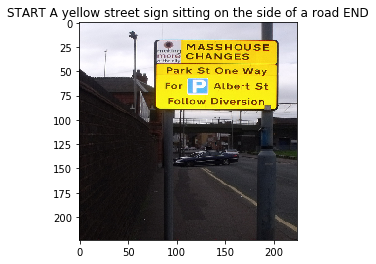

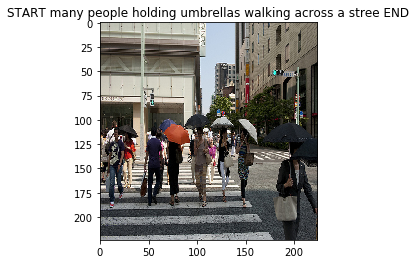

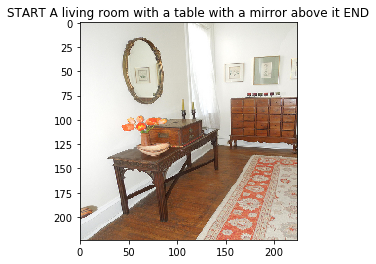

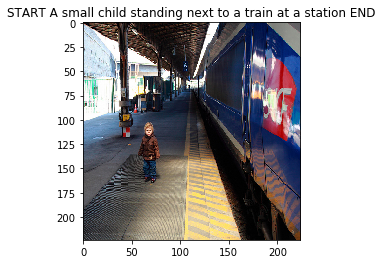

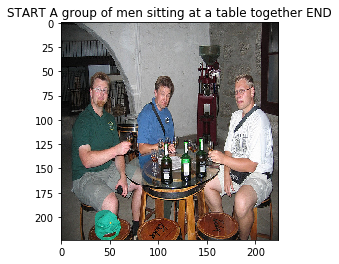

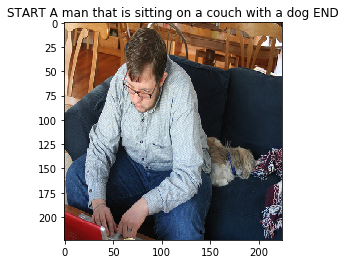

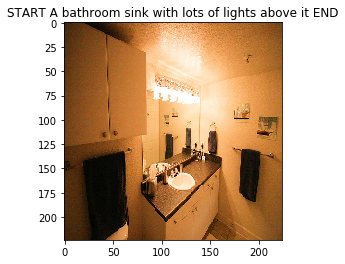

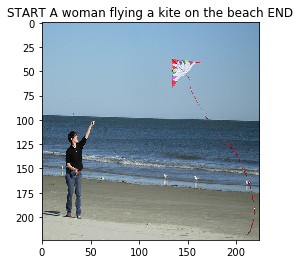

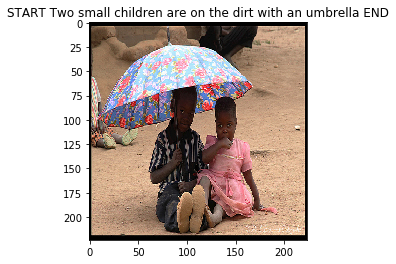

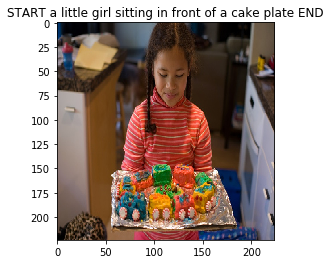

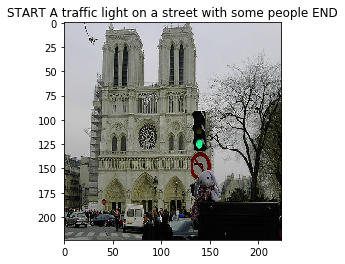

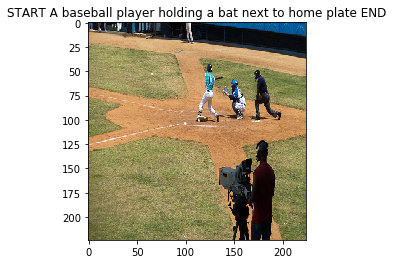

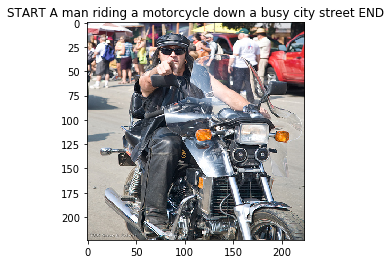

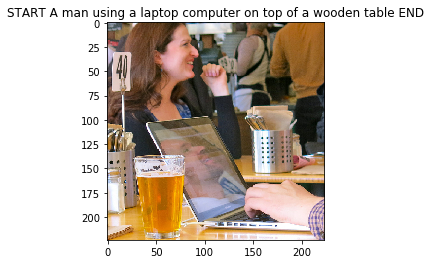

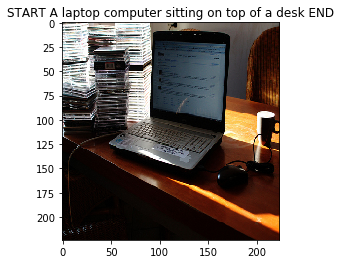

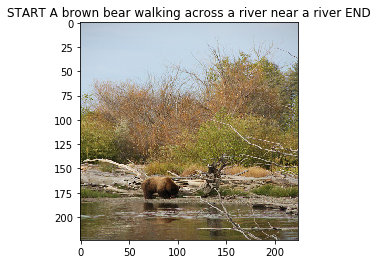

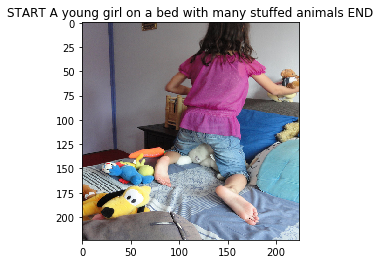

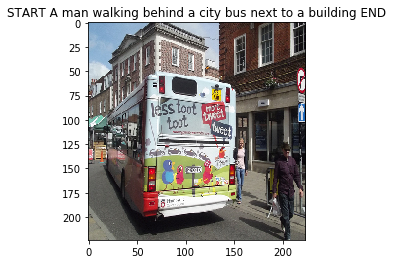

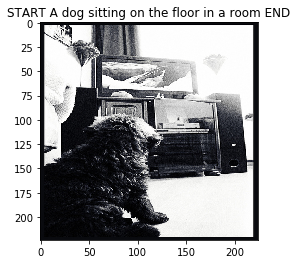

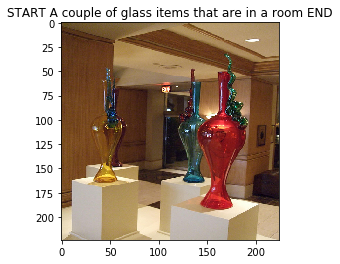

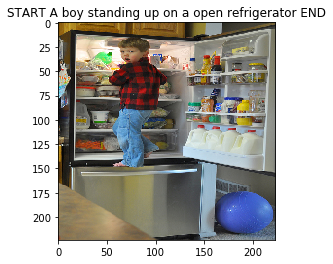

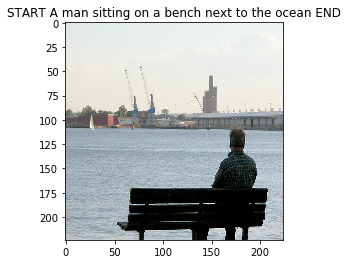

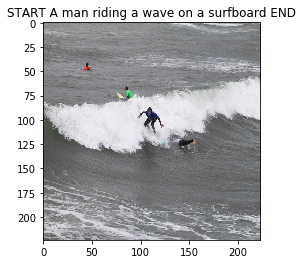

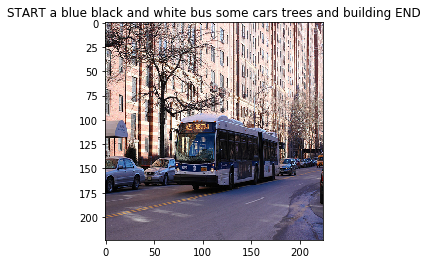

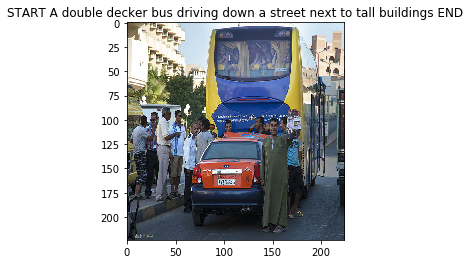

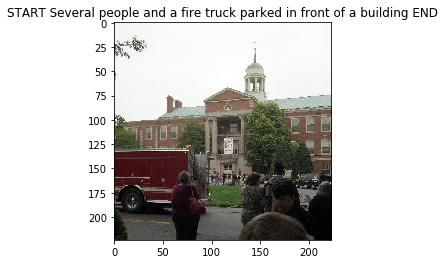

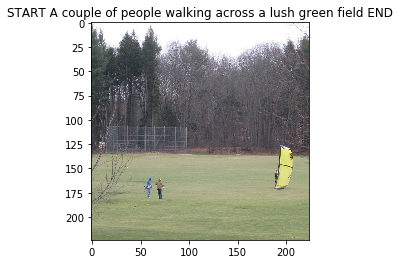

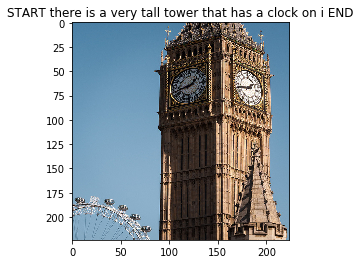

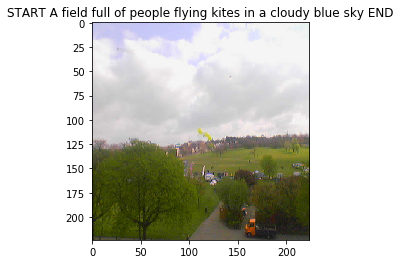

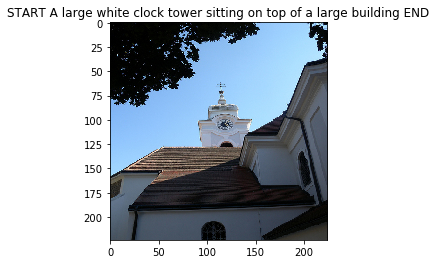

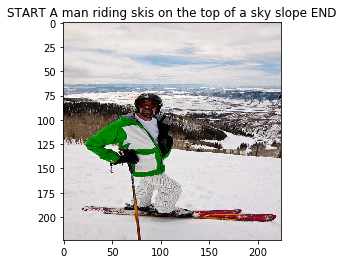

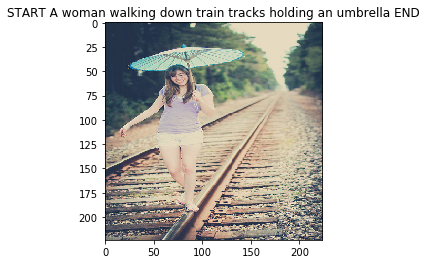

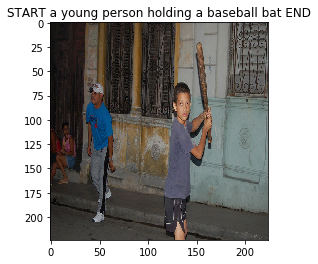

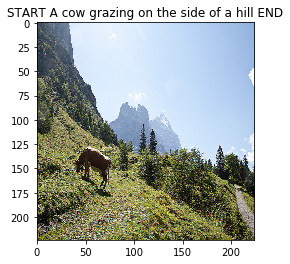

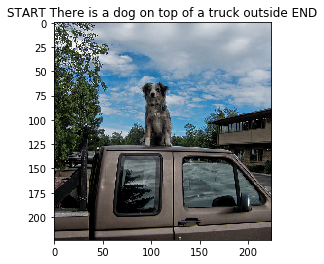

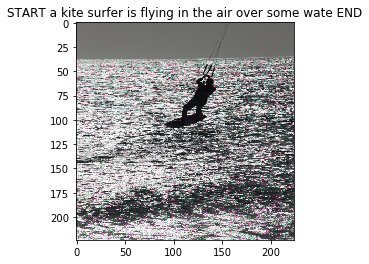

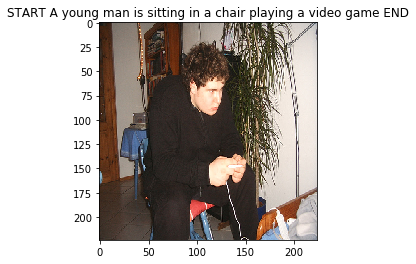

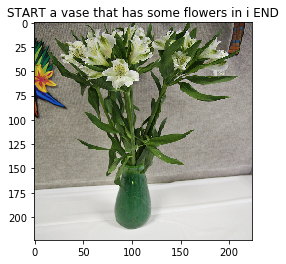

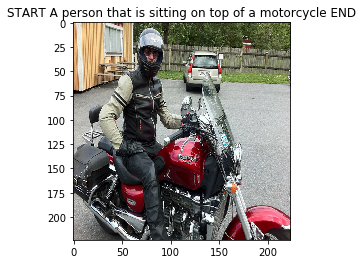

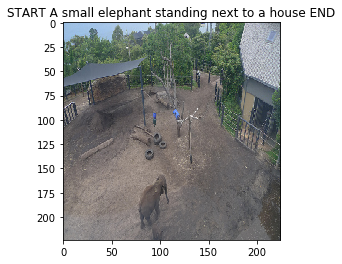

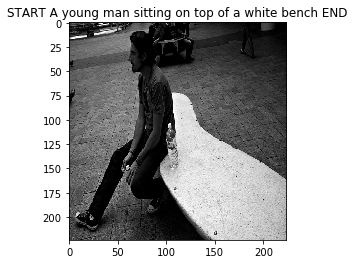

In [26]:
preproc.plot_predictions(imgs,titles = captions)